<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-and-balance-data" data-toc-modified-id="Load-and-balance-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load and balance data</a></span></li><li><span><a href="#XGBoost-classifier" data-toc-modified-id="XGBoost-classifier-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>XGBoost classifier</a></span></li><li><span><a href="#Random-Forest-Classifier" data-toc-modified-id="Random-Forest-Classifier-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Random Forest Classifier</a></span></li><li><span><a href="#Undersampling" data-toc-modified-id="Undersampling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Undersampling</a></span></li><li><span><a href="#Random-Forest-Classifier" data-toc-modified-id="Random-Forest-Classifier-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Random Forest Classifier</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Catboost</a></span></li></ul></div>

In [1]:
from io import BytesIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, plot_confusion_matrix, classification_report, precision_recall_curve
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from typing import Dict, Tuple, Callable
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.n

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive



# Load and balance data

In [0]:
path_f = '/content/drive/My Drive/data/features_train.csv'
path_t = '/content/drive/My Drive/data/target_train.csv'

df_f = pd.read_csv(path_f)
df_t = pd.read_csv(path_t)

data_train = pd.merge(df_f, df_t, on='Id')

# prepare data set
drop_cols = ['Id']
data_feat_sel = data_train.drop(columns=drop_cols)

X = data_feat_sel.drop(columns=['Expected'])
y = data_feat_sel['Expected']

# validation train split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42) # set the seed for reproducibility

In [0]:
over = SMOTE(sampling_strategy='minority', random_state=42)
X_uo, y_uo = over.fit_resample(X_train, y_train)
rus = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
X_uo, y_uo = rus.fit_resample(X_uo, y_uo)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
y_uo

array([0, 0, 0, ..., 2, 2, 2])

Number of class_0 :  3620
Number of class_1 :  3620
Number of class_2 :  3620


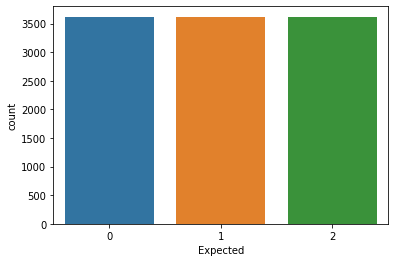

In [0]:
data_train_uo = pd.DataFrame(X_uo)
data_train_uo['Expected'] = y_uo

sns.countplot(data_train_uo['Expected'],label="Count")
class_0, class_1, class_2 = data_train_uo['Expected'].value_counts()
print('Number of class_0 : ',class_0)
print('Number of class_1 : ',class_1)
print('Number of class_2 : ',class_2)

# XGBoost classifier

In [0]:
xgb_clf = XGBClassifier(n_estimators=1000, depth=20, learning_rate=0.1, random_state=42)
xgb_clf.fit(X_uo, y_uo)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, depth=20, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_pred=xgb_clf.predict(X_validation.values)

In [0]:
print(classification_report(y_validation,y_pred))

              precision    recall  f1-score   support

           0       0.17      0.13      0.15       285
           1       0.81      0.74      0.77      1834
           2       0.56      0.70      0.62       881

    accuracy                           0.67      3000
   macro avg       0.51      0.52      0.51      3000
weighted avg       0.67      0.67      0.67      3000



# Random Forest Classifier

In [0]:
pipeline = Pipeline(steps=[('clf', RandomForestClassifier())])

N_ESTIMATORS = [100, 300, 500, 800]
LEARNING_RATE = [0.1, 1, 2]
MAX_DEPTH =  [5, 10, 20, 30]

params = [
    {
        'clf': [RandomForestClassifier(random_state=42)],
        'clf__max_depth' : MAX_DEPTH,
        'clf__n_estimators' : N_ESTIMATORS        
    }#,
    #{
    #    'clf': [XGBClassifier(random_state=42)],
    #    'clf__n_estimators'  : N_ESTIMATORS,
    #    'clf__depth' : MAX_DEPTH,
    #    'clf__learning_rate' : LEARNING_RATE
    #}    
]
grid = GridSearchCV(pipeline, params, cv = 5, scoring = 'f1_macro', refit = 'f1_macro', n_jobs = -1, verbose=1)

In [0]:
grid.fit(X_uo, y_uo)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 13.0min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 33.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                              

In [0]:
grid.best_estimator_

Pipeline(memory=None,
         steps=[('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=30, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=800, n_jobs=None,
                                        oob_score=False, random_state=42,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [0]:
grid.best_params_ 

{'clf': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=30, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=800,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 'clf__max_depth': 30,
 'clf__n_estimators': 800}

              precision    recall  f1-score   support

           0       0.17      0.07      0.10       285
           1       0.78      0.73      0.76      1834
           2       0.53      0.70      0.60       881

    accuracy                           0.66      3000
   macro avg       0.49      0.50      0.49      3000
weighted avg       0.65      0.66      0.65      3000



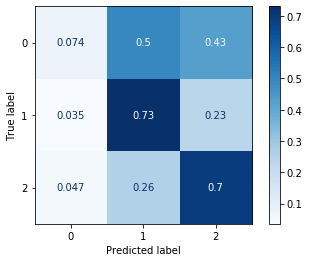

In [0]:
y_pred_rf = grid.predict(X_validation) 
print(classification_report(y_validation,y_pred_rf))


def plot_conf_matrix(classifier, X_test, y_test):
    disp = metrics.plot_confusion_matrix(classifier, X_test, y_test,
                                         cmap=plt.cm.Blues,
                                         normalize='true')
    plt.show()

plot_conf_matrix(grid, X_validation.values, y_validation)

In [0]:
rfclf=RandomForestClassifier(n_estimators=2000, max_depth = 50, random_state=42)
rfclf.fit(X_uo, y_uo)  

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

              precision    recall  f1-score   support

           0       0.16      0.05      0.08       285
           1       0.79      0.74      0.76      1834
           2       0.53      0.71      0.61       881

    accuracy                           0.67      3000
   macro avg       0.49      0.50      0.48      3000
weighted avg       0.65      0.67      0.65      3000



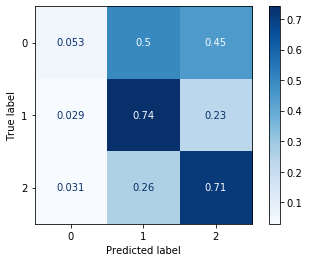

In [0]:
y_pred_rfclf = rfclf.predict(X_validation) 
print(classification_report(y_validation,y_pred_rfclf))

plot_conf_matrix(rfclf, X_validation.values, y_validation)

# Undersampling

(3852, 124) (3852,)
Number of class_0 :  1284
Number of class_1 :  1284
Number of class_2 :  1284


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


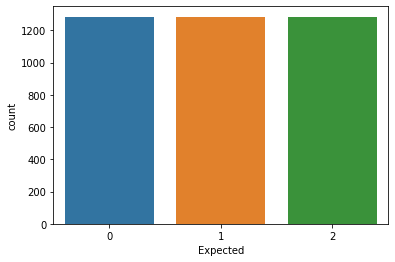

In [4]:
under = RandomUnderSampler(sampling_strategy='auto')
X_u, y_u = under.fit_resample(X_train, y_train)

print(X_u.shape, y_u.shape)
data_train_u = pd.DataFrame(X_u)
data_train_u['Expected'] = y_u

sns.countplot(data_train_u['Expected'],label="Count")
class_0, class_1, class_2 = data_train_u['Expected'].value_counts()
print('Number of class_0 : ',class_0)
print('Number of class_1 : ',class_1)
print('Number of class_2 : ',class_2)

# Random Forest Classifier 

In [0]:
rfclf_2=RandomForestClassifier(n_estimators=2000, max_depth = 50, random_state=42)
rfclf_2.fit(X_u, y_u) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

              precision    recall  f1-score   support

           0       0.27      0.57      0.37       285
           1       0.85      0.68      0.76      1834
           2       0.59      0.63      0.61       881

    accuracy                           0.65      3000
   macro avg       0.57      0.63      0.58      3000
weighted avg       0.72      0.65      0.68      3000



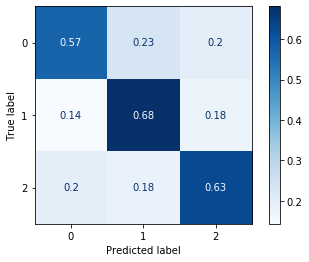

In [0]:
y_pred_rfclf2 = rfclf_2.predict(X_validation) 
print(classification_report(y_validation,y_pred_rfclf2))

def plot_conf_matrix(classifier, X_test, y_test):
    disp = metrics.plot_confusion_matrix(classifier, X_test, y_test,
                                         cmap=plt.cm.Blues,
                                         normalize='true')
    plt.show()

plot_conf_matrix(rfclf_2, X_validation.values, y_validation)

# Catboost

In [5]:
!pip install catboost

     |████████████████████████████████| 64.4MB 76kB/s 


In [0]:
from catboost import CatBoostClassifier

# pipeline
select_K_filter = SelectKBest(f_classif)
clf = RandomForestClassifier()

pipe = Pipeline([('select_K_features', select_K_filter), ('clf', clf)])

K_FEATURES = [10, 20, 50] 
N_ESTIMATORS_F = [1000, 2000]
N_ESTIMATORS_C = [100, 1000]
LEARNING_RATE =  np.arange(0.1, 2, 0.2).tolist()
MAX_DEPTH_F =  [5, 30, 50]
MAX_DEPTH_C =  [2, 8]

params_b = [
    {
        'clf': [RandomForestClassifier(random_state=42)],
        'clf__max_depth' : MAX_DEPTH_F,
        'clf__n_estimators' : N_ESTIMATORS_F,
        'select_K_features__k': K_FEATURES       
    },
    {
        'clf': [CatBoostClassifier(random_seed= 42, task_type='GPU')],
        'clf__n_estimators' : N_ESTIMATORS_C,
        #'clf__depth' : MAX_DEPTH_C
        'select_K_features__k': K_FEATURES
    }
 ]

In [16]:
grid = GridSearchCV(pipe, params_b, cv = 5, scoring = 'f1_macro', refit = 'f1_macro', verbose=2)
grid.fit(X_u, y_u)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] clf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False), clf__max_depth=5, clf__n_estimators=1000, select_K_features__k=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False), clf__max_depth=5, clf__n_estimators=1000, select_K_features__k=10, total=   4.6s
[CV] clf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
  

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


Streaming output truncated to the last 5000 lines.
15:	learn: 0.9499753	total: 143ms	remaining: 8.78s
16:	learn: 0.9435416	total: 151ms	remaining: 8.74s
17:	learn: 0.9384770	total: 160ms	remaining: 8.71s
18:	learn: 0.9331421	total: 168ms	remaining: 8.68s
19:	learn: 0.9271126	total: 176ms	remaining: 8.65s
20:	learn: 0.9219080	total: 185ms	remaining: 8.62s
21:	learn: 0.9180190	total: 193ms	remaining: 8.57s
22:	learn: 0.9142206	total: 201ms	remaining: 8.55s
23:	learn: 0.9106143	total: 216ms	remaining: 8.78s
24:	learn: 0.9062966	total: 228ms	remaining: 8.88s
25:	learn: 0.9015369	total: 236ms	remaining: 8.86s
26:	learn: 0.8974494	total: 245ms	remaining: 8.83s
27:	learn: 0.8939263	total: 254ms	remaining: 8.8s
28:	learn: 0.8882999	total: 263ms	remaining: 8.79s
29:	learn: 0.8836645	total: 271ms	remaining: 8.77s
30:	learn: 0.8802720	total: 280ms	remaining: 8.74s
31:	learn: 0.8752869	total: 288ms	remaining: 8.71s
32:	learn: 0.8704231	total: 297ms	remaining: 8.7s
33:	learn: 0.8657477	total: 307ms

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 25.1min finished


0:	learn: 1.0836591	total: 8.57ms	remaining: 8.57s
1:	learn: 1.0711735	total: 14.8ms	remaining: 7.36s
2:	learn: 1.0595618	total: 21ms	remaining: 6.98s
3:	learn: 1.0491239	total: 27.2ms	remaining: 6.79s
4:	learn: 1.0391463	total: 33.4ms	remaining: 6.65s
5:	learn: 1.0303930	total: 39.7ms	remaining: 6.58s
6:	learn: 1.0212103	total: 46ms	remaining: 6.53s
7:	learn: 1.0127276	total: 52.2ms	remaining: 6.47s
8:	learn: 1.0031662	total: 58.4ms	remaining: 6.43s
9:	learn: 0.9944802	total: 64.7ms	remaining: 6.4s
10:	learn: 0.9866735	total: 70.9ms	remaining: 6.38s
11:	learn: 0.9810207	total: 77.4ms	remaining: 6.37s
12:	learn: 0.9744862	total: 83.7ms	remaining: 6.35s
13:	learn: 0.9677880	total: 89.9ms	remaining: 6.33s
14:	learn: 0.9609991	total: 96ms	remaining: 6.31s
15:	learn: 0.9543614	total: 102ms	remaining: 6.29s
16:	learn: 0.9491585	total: 109ms	remaining: 6.28s
17:	learn: 0.9425311	total: 115ms	remaining: 6.27s
18:	learn: 0.9363274	total: 121ms	remaining: 6.25s
19:	learn: 0.9307177	total: 127ms

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('select_K_features',
                                        SelectKBest(k=10,
                                                    score_func=<function f_classif at 0x7efdb46bbae8>)),
                                       ('clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,


In [17]:
grid.best_estimator_

Pipeline(memory=None,
         steps=[('select_K_features',
                 SelectKBest(k=20,
                             score_func=<function f_classif at 0x7efdb46bbae8>)),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x7efd9e6de898>)],
         verbose=False)

In [18]:
grid.best_params_

{'clf': <catboost.core.CatBoostClassifier at 0x7efd9e6a86a0>,
 'clf__n_estimators': 1000,
 'select_K_features__k': 20}

In [19]:
grid.best_score_

0.6768938968640208

In [0]:
best_clf = grid.best_estimator_.named_steps['clf']
features_sel_ = X_train.columns[grid.best_estimator_.named_steps['select_K_features'].get_support()]

#plot_feature_importance2(best_clf, features_sel_)

In [43]:
features_sel_

Index(['2', '4', '7', '11', '13', '21', '28', '30', '45', '54', '57', '67',
       '71', '72', '76', '87', '107', '113', '116', '122'],
      dtype='object')

In [0]:
sel_ = grid.best_estimator_.named_steps['select_K_features'].get_support()
col_sel_ = X_validation.columns[sel_]
X_validation_sel_ = X_validation[col_sel_]
X_validation_sel_.columns
y_pred_ = grid.best_estimator_.named_steps['clf'].predict(X_validation_sel_.values)

              precision    recall  f1-score   support

           0       0.35      0.72      0.47       285
           1       0.90      0.73      0.81      1834
           2       0.69      0.72      0.70       881

    accuracy                           0.73      3000
   macro avg       0.65      0.72      0.66      3000
weighted avg       0.78      0.73      0.74      3000



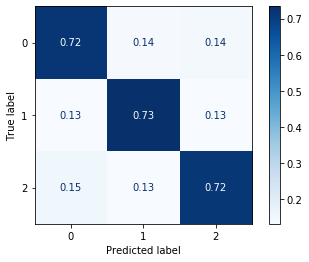

In [22]:
print(classification_report(y_validation,y_pred_))

def plot_conf_matrix(classifier, X_test, y_test):
    disp = metrics.plot_confusion_matrix(classifier, X_test, y_test,
                                         cmap=plt.cm.Blues,
                                         normalize='true')
    plt.show()

plot_conf_matrix(best_clf, X_validation_sel_.values, y_validation)

In [25]:
path_test = '/content/drive/data/features_test.csv'

df_test = pd.read_csv(path_test)

X_test = df_test[col_sel_]
y_pred_test = grid.best_estimator_.named_steps['clf'].predict(X_test) 

df_pred = pd.DataFrame(y_pred_test, columns=['Predicted']) 
df_pred['Id'] = df_pred.index
df_pred = df_pred[['Id', 'Predicted']]
df_pred.reset_index(drop=True)
df_pred.head()

,Id,Predicted
0,0,2
1,1,2
2,2,1
3,3,1
4,4,2


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [27]:
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list:
    print('title: %s, id: %s' % (file1['title'], file1['id']))

title: CERN, id: 1NI-ScxHS-CVY3KbkibVSJtxcxNL7tcFH
title: propulsion, id: 13uOUVK4FTRd19_GMAx9jstCkMVjcPQmJ
title: Tensorflow Basics – @AMLD 1/26-27/19, id: 1omjWcDy2OEquWBszceU7eAlWi5kFPIbEGHq6K3F8rT8
title: amld_data, id: 1BDDx0IKdD0ibp4C6gsL03TKMZDm1H9gB
title: Colab Notebooks, id: 1i_FHzTyEwoJlUxy6OT6sP09HEJwUFSCr
title: Priv, id: 0B4r-MYyLIyFDMVhtSlhXRDFKQ00
title: Phd, id: 0B4r-MYyLIyFDMXJpUVBGZVdOS3c
title: Laurea, id: 0B4r-MYyLIyFDVUZ6Sl83MTQ0cEU


In [0]:
df_pred.to_csv('prediction_1.csv', index=False)
file = drive.CreateFile({'parents':[{u'id': '<id>'}]}) 
file.SetContentFile("prediction_1.csv")
file.Upload()

# score on KAGGLE 0.64991

In [0]:
# pipeline
from sklearn.feature_selection import SelectFdr

select_K_filter_2 = SelectFdr()
clf_2 = RandomForestClassifier()

pipe_2 = Pipeline([('select_K_features', select_K_filter_2), ('clf', clf_2)])

ALPHA = [0.01, 0.03, 0.05, 0.07] 
N_ESTIMATORS_F = [1000, 2000]
N_ESTIMATORS_C = [100, 1000]
LEARNING_RATE =  np.arange(0.1, 2, 0.2).tolist()
MAX_DEPTH_F =  [5, 30, 50]
MAX_DEPTH_C =  [2, 8]

params_b = [
    {
        'clf': [RandomForestClassifier(random_state=42)],
        'clf__max_depth' : MAX_DEPTH_F,
        'clf__n_estimators' : N_ESTIMATORS_F,
        'select_K_features__alpha': ALPHA       
    },
    {
        'clf': [CatBoostClassifier(random_seed= 42, task_type='GPU')],
        'clf__n_estimators' : N_ESTIMATORS_C,
        #'clf__depth' : MAX_DEPTH_C
        'select_K_features__alpha': ALPHA
    }
 ]

In [35]:
grid_2 = GridSearchCV(pipe_2, params_b, cv = 5, scoring = 'f1_macro', refit = 'f1_macro', verbose=2)
grid_2.fit(X_u, y_u)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] clf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False), clf__max_depth=5, clf__n_estimators=1000, select_K_features__alpha=0.01 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False), clf__max_depth=5, clf__n_estimators=1000, select_K_features__alpha=0.01, total=   5.9s
[CV] clf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


Streaming output truncated to the last 5000 lines.
15:	learn: 0.9488296	total: 103ms	remaining: 6.34s
16:	learn: 0.9417673	total: 110ms	remaining: 6.34s
17:	learn: 0.9357301	total: 117ms	remaining: 6.38s
18:	learn: 0.9302867	total: 124ms	remaining: 6.38s
19:	learn: 0.9238634	total: 130ms	remaining: 6.36s
20:	learn: 0.9185442	total: 136ms	remaining: 6.34s
21:	learn: 0.9133550	total: 142ms	remaining: 6.32s
22:	learn: 0.9073651	total: 149ms	remaining: 6.31s
23:	learn: 0.9027510	total: 155ms	remaining: 6.3s
24:	learn: 0.8965349	total: 165ms	remaining: 6.45s
25:	learn: 0.8922937	total: 172ms	remaining: 6.45s
26:	learn: 0.8873691	total: 179ms	remaining: 6.43s
27:	learn: 0.8836881	total: 185ms	remaining: 6.42s
28:	learn: 0.8782621	total: 192ms	remaining: 6.42s
29:	learn: 0.8742781	total: 198ms	remaining: 6.4s
30:	learn: 0.8710882	total: 209ms	remaining: 6.54s
31:	learn: 0.8664341	total: 215ms	remaining: 6.52s
32:	learn: 0.8621464	total: 222ms	remaining: 6.5s
33:	learn: 0.8587942	total: 228ms	

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 30.6min finished


0:	learn: 1.0836591	total: 9.29ms	remaining: 9.28s
1:	learn: 1.0711736	total: 16.3ms	remaining: 8.13s
2:	learn: 1.0595618	total: 23.2ms	remaining: 7.72s
3:	learn: 1.0491239	total: 30.2ms	remaining: 7.51s
4:	learn: 1.0391463	total: 36.8ms	remaining: 7.32s
5:	learn: 1.0303930	total: 43.4ms	remaining: 7.2s
6:	learn: 1.0212103	total: 50.1ms	remaining: 7.11s
7:	learn: 1.0127276	total: 60.8ms	remaining: 7.54s
8:	learn: 1.0031662	total: 68ms	remaining: 7.49s
9:	learn: 0.9944802	total: 75.6ms	remaining: 7.49s
10:	learn: 0.9866735	total: 82.5ms	remaining: 7.42s
11:	learn: 0.9810207	total: 94.6ms	remaining: 7.79s
12:	learn: 0.9744862	total: 102ms	remaining: 7.75s
13:	learn: 0.9677880	total: 110ms	remaining: 7.72s
14:	learn: 0.9609992	total: 117ms	remaining: 7.71s
15:	learn: 0.9543615	total: 124ms	remaining: 7.64s
16:	learn: 0.9491585	total: 131ms	remaining: 7.57s
17:	learn: 0.9425311	total: 138ms	remaining: 7.5s
18:	learn: 0.9363273	total: 144ms	remaining: 7.44s
19:	learn: 0.9307178	total: 151ms

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('select_K_features',
                                        SelectFdr(alpha=0.05,
                                                  score_func=<function f_classif at 0x7efdb46bbae8>)),
                                       ('clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None

In [36]:
grid_2.best_params_

{'clf': <catboost.core.CatBoostClassifier at 0x7efd918c9588>,
 'clf__n_estimators': 1000,
 'select_K_features__alpha': 0.01}

In [0]:
best_clf_2 = grid_2.best_estimator_.named_steps['clf']
features_sel_2 = X_train.columns[grid_2.best_estimator_.named_steps['select_K_features'].get_support()]

In [42]:
features_sel_2

Index(['2', '4', '7', '11', '13', '21', '28', '30', '45', '54', '57', '67',
       '71', '72', '76', '87', '107', '113', '116', '122'],
      dtype='object')

In [0]:
sel_2 = grid_2.best_estimator_.named_steps['select_K_features'].get_support()
col_sel_2 = X_validation.columns[sel_2]
X_validation_sel_2 = X_validation[col_sel_2]
X_validation_sel_2.columns
y_pred_2 = grid_2.best_estimator_.named_steps['clf'].predict(X_validation_sel_2.values)

              precision    recall  f1-score   support

           0       0.35      0.72      0.47       285
           1       0.90      0.73      0.81      1834
           2       0.69      0.72      0.70       881

    accuracy                           0.73      3000
   macro avg       0.65      0.72      0.66      3000
weighted avg       0.78      0.73      0.74      3000



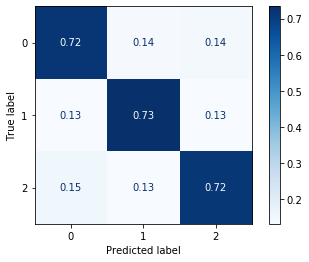

In [39]:
print(classification_report(y_validation,y_pred_2))

def plot_conf_matrix(classifier, X_test, y_test):
    disp = metrics.plot_confusion_matrix(classifier, X_test, y_test,
                                         cmap=plt.cm.Blues,
                                         normalize='true')
    plt.show()

plot_conf_matrix(best_clf_2, X_validation_sel_2.values, y_validation)

In [40]:
y_pred_test_2 = grid_2.best_estimator_.named_steps['clf'].predict(X_test) 

df_pred_2 = pd.DataFrame(y_pred_test_2, columns=['Predicted']) 
df_pred_2['Id'] = df_pred_2.index
df_pred_2 = df_pred_2[['Id', 'Predicted']]
df_pred_2.reset_index(drop=True)
df_pred_2.head()

,Id,Predicted
0,0,2
1,1,2
2,2,1
3,3,1
4,4,2


In [0]:
df_pred_2.to_csv('prediction_2.csv', index=False)
file = drive.CreateFile({'parents':[{u'id': '<id>'}]}) 
file.SetContentFile("prediction_2.csv")
file.Upload() # KAGGLE SCORE = 0.64991